To do:
- SPSA Optmizer, como funciona a função do qistkit
- O que é o threshold
- A função treino
- 
- 

Anotações:
- o Uw é só introduzir $(-1)*\phi$ do mesmo jeito que foi introduzido o $\theta$
- normalmente o tamanho de theta é uma potência de 2
- as portas $X$ são colocadas no cicuito de modo a aplicar a operação $R$ somente ao estado desejado (visto que a porta $R$, da maneira que implementamos, só é aplicada quando o estado atual é $|11>$)
- Existe uma porta $P$ que faz o que implementamos como rzao
- Lembrar de fazer o theta til em vez de só theta

In [ ]:
!pip install qiskit
!pip install pennylane --upgrade
!pip install --upgrade tensorflow
!pip install matplotlib

In [1]:
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import SPSA
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


import numpy as np

## $U_i$

In [2]:
def Ui(theta:[float]):

    numQubits = int(np.log2(len(theta)))

    register = QuantumRegister(numQubits)

    circuito = QuantumCircuit(register, name = "U(i)")

    circuito.h(range(numQubits))

    thetaTil = list(map(lambda x: x-theta[0], theta[1:]))

    for i in range(len(thetaTil)):

        num = bin(i+1)[2:].zfill(numQubits)

        count=0 # essa variavel vai guardar em que posicao na string estamos

        for j in num: # iterando pelos caracteres de num

            if(j=='0'):

                circuito.x(count)

            count+=1

        circuito.mcp(thetaTil[i], list(range(len(num)-1)), len(num)-1)

        count=0 # essa variavel vai guardar em que posicao na string estamos

        for j in num: # iterando pelos caracteres de num

            if(j=='0'):

                circuito.x(count) # desfazendo os nots

            count+=1

    return circuito.to_gate()

In [3]:
thetaEx = [10, 12, 13, 11]

register1 = QuantumRegister(2, name='qr')

circuito = QuantumCircuit(register1)
circuito.append(Ui(thetaEx), [0,1])

circuito.decompose().draw()

┌───┐┌───┐       ┌───┐                   
qr_0: ┤ H ├┤ X ├─■─────┤ X ├─■───────────■─────
      ├───┤└───┘ │P(2) ├───┤ │P(3) ┌───┐ │P(1) 
qr_1: ┤ H ├──────■─────┤ X ├─■─────┤ X ├─■─────
      └───┘            └───┘       └───┘

## $U_w$

In [4]:
def Uw(phi:[float]):

    numQubits = int(np.log2(len(phi)))

    register = QuantumRegister(numQubits)

    circuito = QuantumCircuit(register, name = "U(w)")   

    phiTil = list(map(lambda x: (x-phi[0])*(-1), phi[1:])) # Phase(lambda)^daga == Phase(-lambda)

    for i in range(len(phiTil)):

        num = bin(i+1)[2:].zfill(numQubits)

        count=0 # essa variavel vai guardar em que posicao na string estamos

        for j in num: # iterando pelos caracteres de num

            if(j=='0'):

                circuito.x(count)

            count+=1

        circuito.mcp(phiTil[i], list(range(len(num)-1)), len(num)-1)

        count=0 # essa variavel vai guardar em que posicao na string estamos

        for j in num: # iterando pelos caracteres de num

            if(j=='0'):

                circuito.x(count) # desfazendo os nots

            count+=1

    circuito.h(range(numQubits))

    circuito.x(range(numQubits))

    return circuito.to_gate()

In [5]:
phiEx = [10, 12, 13, 11]

register1 = QuantumRegister(2, name='qr')

circuito = QuantumCircuit(register1)
circuito.append(Uw(phiEx), [0,1])

circuito.decompose().draw()

┌───┐        ┌───┐                     ┌───┐┌───┐
qr_0: ┤ X ├─■──────┤ X ├─■────────────■──────┤ H ├┤ X ├
      └───┘ │P(-2) ├───┤ │P(-3) ┌───┐ │P(-1) ├───┤├───┤
qr_1: ──────■──────┤ X ├─■──────┤ X ├─■──────┤ H ├┤ X ├
                   └───┘        └───┘        └───┘└───┘

## Teste

In [6]:
register = QuantumRegister(2)

register2 = QuantumRegister(1, name='output')

classicalBit = ClassicalRegister(1)

circuito = QuantumCircuit(register, register2, classicalBit)

thetaEx = [np.pi/6, np.pi/4, np.pi/2, np.pi]
phiEx = [0, np.pi/2, np.pi/4, np.pi/6]

circuito.append(Ui(thetaEx), [0,1])
circuito.barrier()
circuito.append(Uw(phiEx), [0,1])
circuito.barrier()

circuito.mcx([0,1], 2)

circuito.measure(2,0)

circuito.draw()

┌───────┐ ░ ┌───────┐ ░         
  q2_0: ┤0      ├─░─┤0      ├─░───■─────
        │  U(i) │ ░ │  U(w) │ ░   │     
  q2_1: ┤1      ├─░─┤1      ├─░───■─────
        └───────┘ ░ └───────┘ ░ ┌─┴─┐┌─┐
output: ──────────░───────────░─┤ X ├┤M├
                  ░           ░ └───┘└╥┘
  c0: 1/══════════════════════════════╩═
                                      0

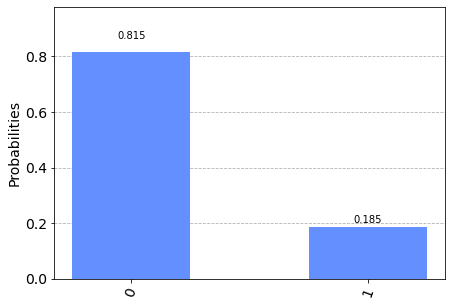

In [7]:
sim = Aer.get_backend('aer_simulator')  # Tell Qiskit how to simulate our circuit

qobj = assemble(circuito.decompose())     # Create a Qobj from the circuit for the simulator to run
counts = sim.run(qobj).result().get_counts()
plot_histogram(counts)

In [333]:
n_epochs = 30   # Number of optimization epochs
n_train = 50    # Size of the train dataset
n_test = 30
n_batch = 5     # Size of the test dataset
threshold = 0.85
spsa = SPSA(maxiter=20,blocking= True)

### Pre processamento

In [320]:
mnist_dataset = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist_dataset.load_data()

train_mask = np.isin(Y_train, [0,1])
test_mask = np.isin(Y_test, [0,1])

X_train, Y_train = X_train[train_mask], np.array(Y_train[train_mask] == 1)
X_test, Y_test = X_test[test_mask], np.array(Y_test[test_mask] == 1)


In [314]:
mnist_dataset = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist_dataset.load_data()

In [325]:
print(Y_test)

[ True False  True False False  True False False  True  True  True  True
  True  True False  True False False  True  True  True  True False  True
 False  True False  True  True  True]


### Diminuindo o tamanho das amostras

In [322]:
weightImageOne = X_test[51] #number one 51

X_train = X_train[:n_train]
Y_train = Y_train[:n_train]

X_test = X_test[:n_test]
Y_test = Y_test[:n_test]

### Normalizando as amostras entre zero e $\pi$

In [324]:
X_train = (X_train/255)*(np.pi/2)
X_test= (X_test/255)*(np.pi/2)

weightImageOne = (weightImageOne/255)*(np.pi/2)

In [276]:
for i in Y_train:
    print(i)

False
True
True
True
True
False
True
True
False
False
True
False
False
True
False
True
False
False
True
True
False
True
True
False
False
False
True
True
True
True
False
True
True
False
False
False
False
True
True
True
True
False
False
True
True
True
False
True
True
True


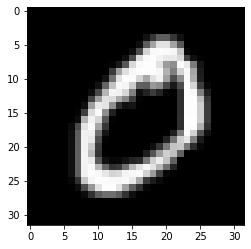

In [328]:
X_train = np.expand_dims(X_train, axis=-1)
X_train = tf.image.resize(X_train, [32,32])

X_test = np.expand_dims(X_test, axis=-1)
X_test = tf.image.resize(X_test, [32,32])

weightImageOne = np.expand_dims(weightImageOne, axis=-1)
weightImageOne = tf.image.resize(weightImageOne, [32,32])
plt.imshow(X_train[0], cmap= "gray")
plt.show()

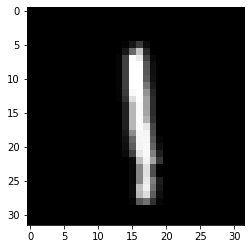

False


In [265]:
plt.imshow(X_train[3], cmap= "gray")
plt.show()
print(Y_train[0])

### Transformando imagem em lista de array

In [266]:
def transformImageInArray(image):
    imageArray = []
    for i in range(32):
        for j in range(32):
            imageArray.append(float(image[i][j]))
    return imageArray

### Criando Circuito

In [267]:
def createCircuit(imageArray, weightArray):
    numQbits = int(np.log2(len(weightArray)))

    register = QuantumRegister(numQbits)
    output = QuantumRegister(1, name='output')
    classicalBit = ClassicalRegister(1)

    circuit = QuantumCircuit(register, output, classicalBit)

    circuit.append(Ui(imageArray), [0,1,2,3,4,5,6,7,8,9])
    circuit.barrier()
    circuit.append(Uw(weightArray), [0,1,2,3,4,5,6,7,8,9])
    circuit.mcx([0,1,2,3,4,5,6,7,8,9], 10)
    circuit.measure(10,0)
    return circuit

### Funçoes auxiliares

In [202]:
def getlost(ytil, y):
    return (y - ytil)**2

In [271]:
def loss(weight):

    circuit = createCircuit(transformImageInArray(imagem), weight)
    sim = Aer.get_backend('aer_simulator')  # Tell Qiskit how to simulate our circuit
    qobj = assemble(circuit.decompose())     # Create a Qobj from the circuit for the simulator to run
    counts = sim.run(qobj).result().get_counts()
    print("Keys: "+str(counts.keys()))
    print(counts)
    try:
        if(counts['1']/1024 > threshold): ytil = 1 
        else: ytil = 0
    except:
        ytil = 0
    return getlost(ytil, imagemLabel)

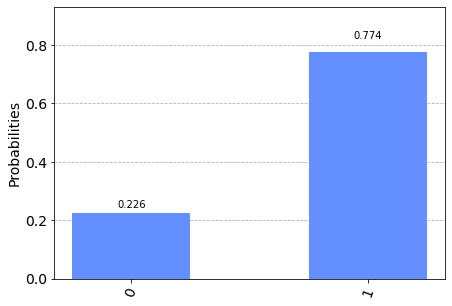

In [334]:
circuit = createCircuit(transformImageInArray(X_train[8]), weightArray)
sim = Aer.get_backend('aer_simulator')  # Tell Qiskit how to simulate our circuit
qobj = assemble(circuit.decompose())     # Create a Qobj from the circuit for the simulator to run
counts = sim.run(qobj).result().get_counts()
plot_histogram(counts)


In [ ]:
imagem = X_train[4]
imagemLabel = Y_train[4]
weightArray = transformImageInArray(weightImageOne)
for i in range(50):
    imagem = X_train[i]
    imagemLabel = Y_train[i]
    weightArray = spsa.optimize(num_vars = 1024, variable_bounds= list((0, np.pi/2) for i in range (1024)), objective_function = loss ,initial_point=weightArray)[0]
    


## Train

In [355]:
count = 0
count0 = 0
count1 = 0
for i in range(30):
    circuit = createCircuit(transformImageInArray(X_test[i]), weightArray)
    sim = Aer.get_backend('aer_simulator')  # Tell Qiskit how to simulate our circuit
    qobj = assemble(circuit.decompose())     # Create a Qobj from the circuit for the simulator to run
    counts = sim.run(qobj).result().get_counts()
    if (counts['1']/1024 > threshold):
        result = 1
    else:
        result = 0
    #print("Result: "+str(result)+ " Label: "+str(Y_test[i]))
    if result == Y_test[i]:
        count += 1
    else:
        if result == 0:
            count0 += 1
        else:
            count1 += 1
    
print(count/30)
print("erro 0: "+str(count0) + str(count0/30))
print("erro 1: "+str(count1) + str(count1/30))

1.0
erro 0: 00.0
erro 1: 00.0


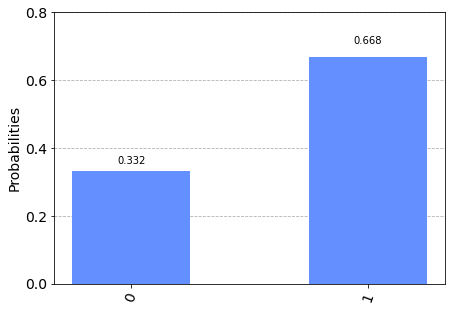

In [349]:
circuit = createCircuit(transformImageInArray(X_test[7]), weightArray)
sim = Aer.get_backend('aer_simulator')  # Tell Qiskit how to simulate our circuit
qobj = assemble(circuit.decompose())     # Create a Qobj from the circuit for the simulator to run
counts = sim.run(qobj).result().get_counts()
plot_histogram(counts)

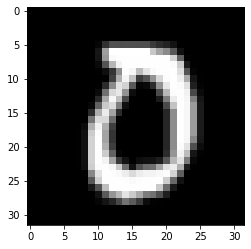

In [351]:
plt.imshow(X_test[7], cmap= "gray")
plt.show()